In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import numpy as np
import copy

In [2]:
from OpSimSummary import summarize_opsim as oss
import sncosmo

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from metrics import PerSNMetric
from efficiencyTable import EfficiencyTable

In [4]:
from lsst.sims.photUtils import BandpassDict

In [5]:
from lsst.sims.utils.coordinateTransformations import haversine

In [6]:
# Catsim bandpasses
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [7]:
# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


In [8]:
import psops as testps

In [9]:
lsstReq = testps.LSSTReq

In [74]:
lsstReq

{'Duration': 3650.0, 'bF': u    1
 g    1
 r    1
 i    1
 z    1
 y    1
 dtype: float64, 'meanNumVisits': u     56
 g     80
 r    184
 i    184
 z    160
 y    160
 dtype: float64, 'medianSVD': u    23.9
 g    25.0
 r    24.7
 i    24.0
 z    23.3
 y    22.1
 dtype: float64}

In [10]:
x = testps.LSST_Obs(mjd_center=49540, lsstrequirements=lsstReq)

In [11]:
x.bumpFactors

u    1
g    1
r    1
i    1
z    1
y    1
dtype: float64

In [70]:
lc = x.obsValues()

AttributeError: 'DataFrame' object has no attribute 'obsValues'

In [71]:
lc.head()

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night
0,49510.000000,g,0,0,25,1,49510
1,49536.666667,g,0,0,25,1,49536
2,49563.333333,g,0,0,25,1,49563
3,49510.000000,i,0,0,24,1,49510
4,49526.000000,i,0,0,24,1,49526


In [72]:
y = testps.LSST_Obs(mjd_center=49540, lsstrequirements=lsstReq, timeWindow=[-20., 50.])

In [73]:
y.meanNumObsperBand

u    1
g    2
r    4
i    4
z    3
y    3
dtype: float64

In [50]:
y.bumpFactors = [1., 1.5, 1., 0.75, 1., 0.]

In [52]:
lc_309 = y.obsValues()

In [67]:
q_309 = PerSNMetric(summarydf=lc_309, t0=49540, raCol='ra', decCol='dec', lsst_bp=lsst_bp, fieldID=None)

In [54]:
q_309_mcmc_out = sncosmo.mcmc_lc(q_309.SNCosmoLC(nightlyCoadd=True), model=q.sncosmoModel,
                                vparam_names=['t0', 'x0', 'x1', 'c'],
                                bounds={'c':(-1., 1.), 'x1':(-5.0, 5.0)}, 
                                minsnr=0.)

metrics.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['SNR'] = df['flux'] / df['fluxerr']
metrics.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['DetectionEfficiency'] = df.apply(self.func, axis=1)


19


metrics.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.sort_values('SNR', ascending=False, inplace=True)


In [68]:
q_309_out = ans.ResChar.fromSNCosmoRes(q_309_mcmc_out)

metrics.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['modelFlux'] = lc['flux']
metrics.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['deviation'] = np.random.normal(size=len(lc['flux']))


19


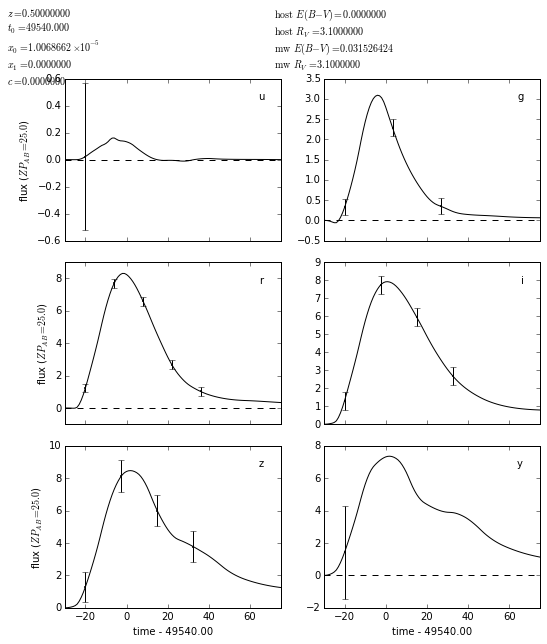

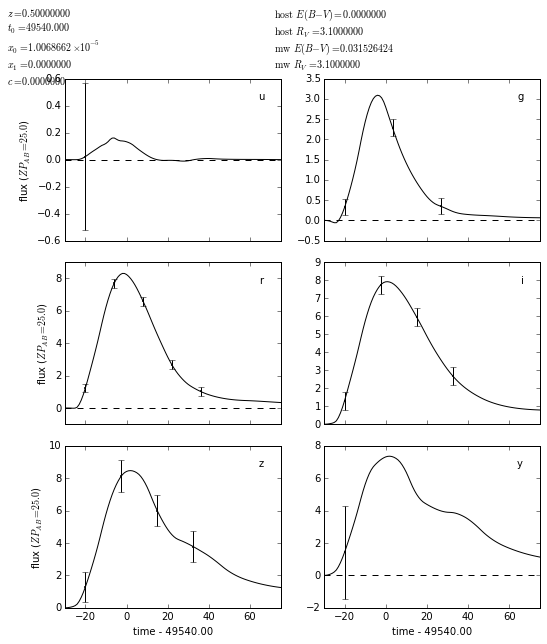

In [69]:
q_309.lcplot()

In [ ]:
lc

In [63]:
lc_309.head()

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night
0,49520.000000,g,0,0,25,1,49520
1,49543.333333,g,0,0,25,1,49543
2,49566.666667,g,0,0,25,1,49566
3,49520.000000,i,0,0,24,1,49520
4,49537.500000,i,0,0,24,1,49537


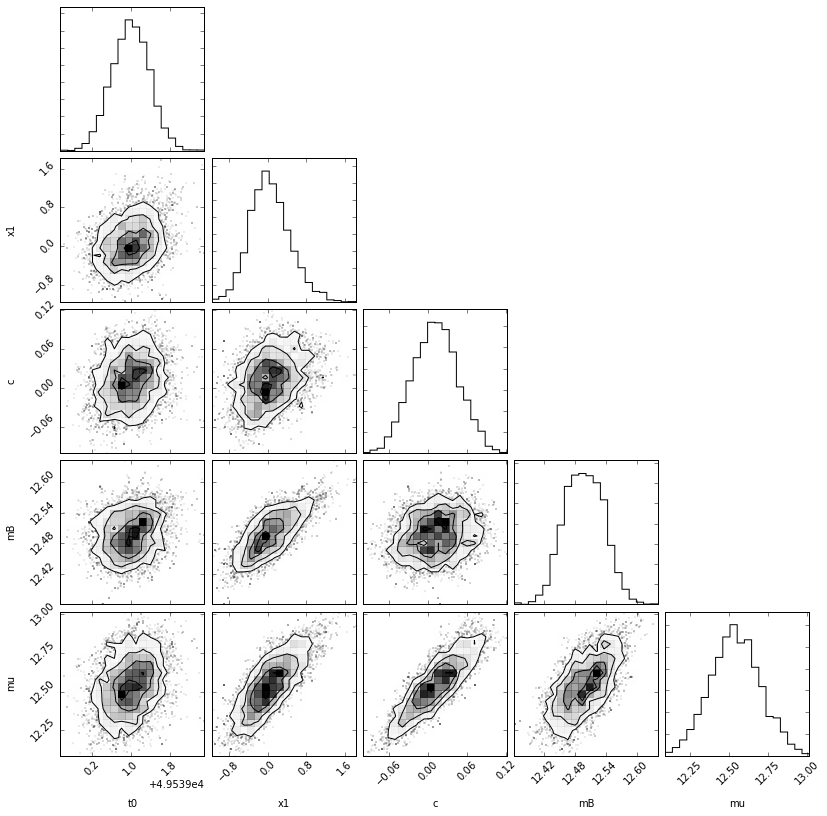

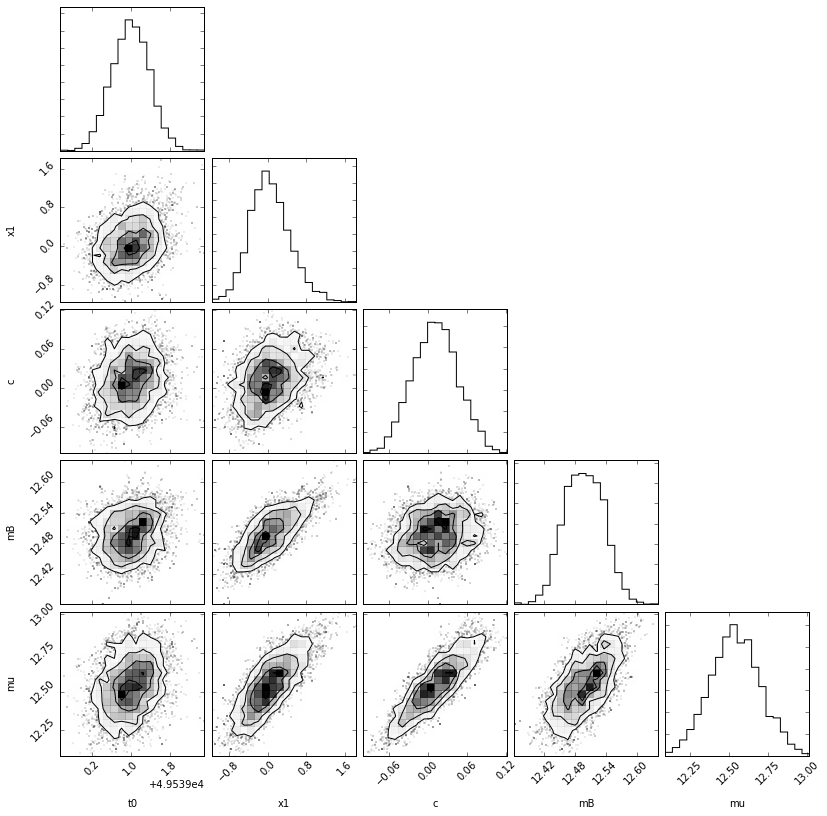

In [60]:
corner(q_309.salt_samples(), labels=q_309.salt_samples().columns)

In [14]:
q = PerSNMetric(summarydf=lc, t0=49540, raCol='ra', decCol='dec', lsst_bp=lsst_bp, fieldID=None)

In [ ]:
q = Per

In [15]:
mcmc_out = sncosmo.mcmc_lc(q.SNCosmoLC(nightlyCoadd=True), model=q.sncosmoModel, 
                vparam_names=['t0', 'x0', 'x1', 'c'], 
                bounds={'c':(-1., 1.), 'x1':(-5.0, 5.0)}, 
                minsnr=0.)

19


In [16]:
mcmc_out_mc = sncosmo.mcmc_lc(q.SNCosmoLC(nightlyCoadd=True), model=q.sncosmoModel, 
                vparam_names=['t0', 'x0', 'x1', 'c'], 
                bounds={'c':(-1., 1.), 'x1':(-5.0, 5.0)}, 
                minsnr=0., modelcov=True)

In [20]:
import analyzeSN as ans
from corner import corner

In [23]:
noscatter = ans.ResChar.fromSNCosmoRes(mcmc_out)
withScatter  = ans.ResChar.fromSNCosmoRes(mcmc_out_mc)

In [37]:
noscatter.salt_samples().columns

Index([u't0', u'x1', u'c', u'mB', u'mu'], dtype='object')

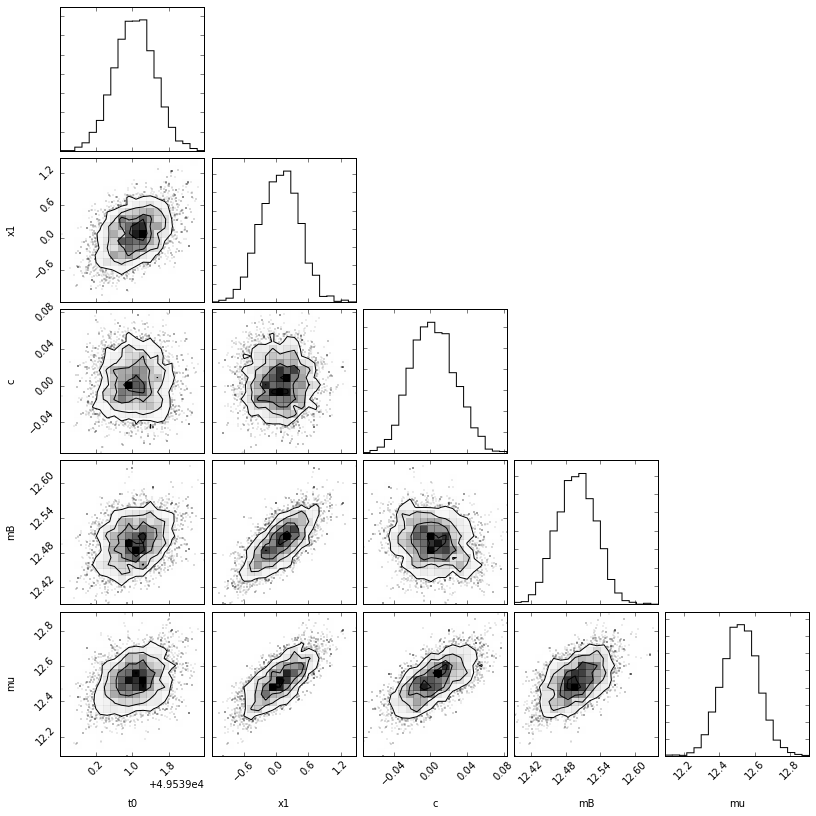

In [44]:
fig_noScatter = corner(noscatter.salt_samples().values, labels=noscatter.salt_samples().columns)

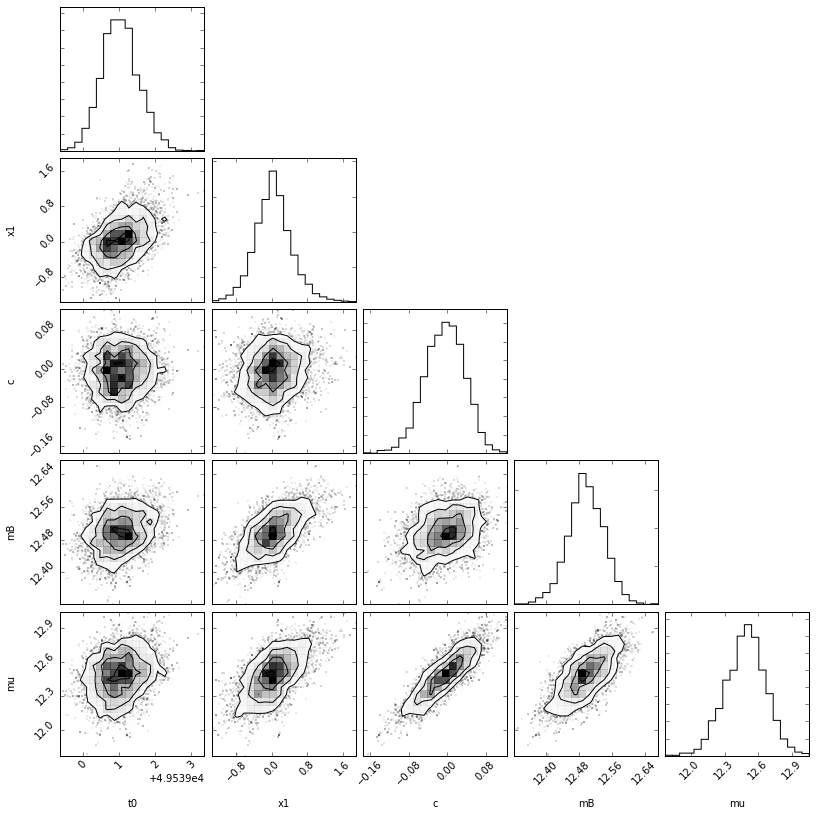

In [45]:
fig_Scatter = corner(withScatter.salt_samples().values, labels=withScatter.salt_samples().columns)

IndexError: list assignment index out of range

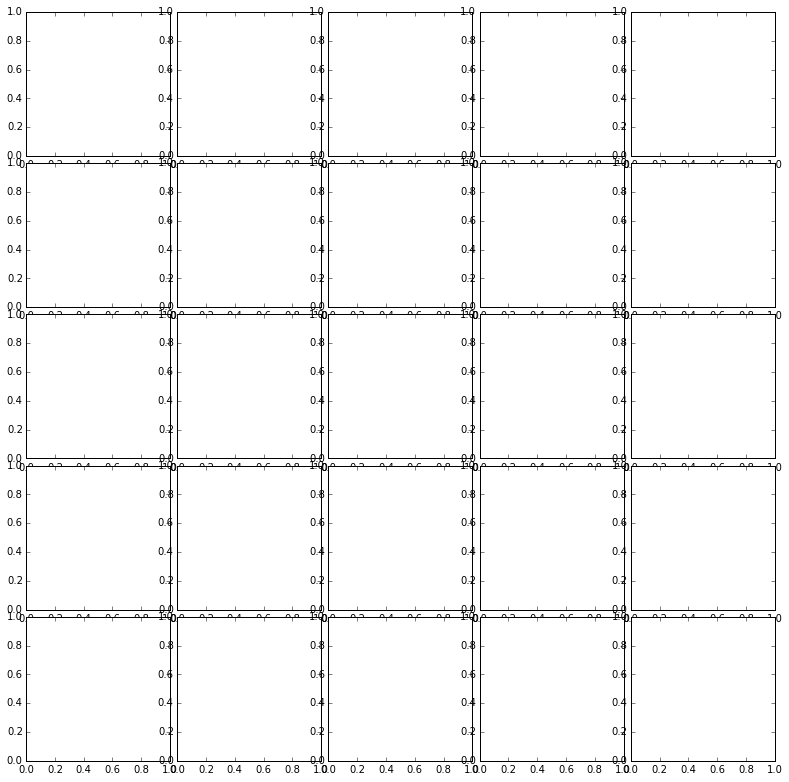

In [36]:
fig_noScatter = corner(noscatter.salt_samples(), noscatter.salt_samples().columns)

In [17]:
fig_mc = corner(mcmc_out_mc[0].samples, labels=mcmc_out_mc[0].vparam_names, scale_hist=True)

NameError: name 'corner' is not defined

In [ ]:
q.lcplot(scattered=True, nightlyCoadd=False)

In [ ]:
from corner import corner

In [ ]:
fig = corner(mcmc_out[0].samples, labels=mcmc_out[0].vparam_names, scale_hist=True)

In [ ]:
fit_errs = q.fits[0].errors

In [ ]:
fit_errs

In [ ]:
(mcmc_out[0].covariance - q.fits[0].covariance ) / mcmc_out[0].covariance

In [ ]:
q.deltamusq ** 0.5

In [ ]:
print(mcmc_out_mc[0].errors, mcmc_out[0].errors)

# Scratch

In [ ]:
opsimHDF = os.path.join(os.getenv('HOME'), 'data', 'LSST', 'OpSimData', 'storage.h5')
summarydf = pd.read_hdf(opsimHDF, 'table')



In [ ]:
summarydf.query('fieldID == 290')[['fieldRA', 'fieldDec']].head()

In [ ]:
posns = pd.read_csv('example_data/posns.txt', delim_whitespace=True)

In [ ]:
posns['ra_radians']= np.radians(posns.RAdeg)
posns['dec_radians']= np.radians(posns.Decdeg)

In [ ]:
posns.ix[0, 'ra_radians']

In [ ]:
radius = np.radians(1.75)

In [ ]:
def distance(ra1, dec1, ra2, dec2):
    """
    Obtain the angular distance in radians between two points with given
    ra, dec values in radians
    
    Parameters
    ----------
    ra1 : array like, mandatory
    dec1 :
    ra2 :
    dec2 :
    """
    cosDelta = np.cos(dec1)* np.cos(dec2) *np.cos(ra1 -ra2) + np.sin(dec1)*np.sin(dec2)
    return np.arccos(cosDelta)

In [ ]:
def _obsForSN(summarydf, ind):
    summarydf['observed'] = 0
    summarydf['distance'] = distance(summarydf['ditheredRA'], 
                                     summarydf['ditheredDec'],
                                     #ra, dec)
                                     posns.ix[ind, 'ra_radians'], 
                                     posns.ix[ind, 'dec_radians'])
    
    summarydf.ix[summarydf.distance < radius, 'observed'] = 1
    return summarydf.groupby('observed').get_group(1)

In [ ]:
qm_0 = PerSNMetric(t0=49484, summarydf=_obsForSN(summarydf, 0), lsst_bp=lsst_bp, raCol='ditheredRA', decCol='ditheredDec')

In [ ]:
qm_0.lsst_bp[qm_0.df['filter'].iloc[0]].wavelen

In [ ]:
dftest = qm_0.df.copy()

In [ ]:
dftest['filter'].apply(lambda x: x.lower())

In [ ]:
dftest['filter'] = dftest['filter'].apply(lambda x: x.lower())

In [ ]:
'Y' in dftest['filter']

In [ ]:
dftest.apply(lambda row: qm_0.SN.catsimBandFluxes(row['expMJD'], 
                                                  qm_0.lsst_bp[row['filter']]),axis=1)

In [ ]:
band in qm_0.df.columns

In [ ]:
qm_0.lcplot(nightlyCoadd=True)

In [ ]:
x = qm_0.SNCosmoLC()

In [ ]:
model = sncosmo

In [ ]:
qm_0.sncosmoModel

In [ ]:
print(qm_0.sncosmoModel)

In [ ]:
mcmc_out = sncosmo.mcmc_lc(x, model=qm_0.sncosmoModel, 
                vparam_names=['t0', 'x0', 'x1', 'c'], 
                bounds={'c':(-0.3, 0.3), 'x1':(-3.0, 3.0)}, 
                minsnr=0.)

In [ ]:
mcmc_out[0]['samples']

In [ ]:
mcmc_out[0].keys()

In [ ]:
import corner

In [ ]:
corner.corner(mcmc_out[0].samples, labels=mcmc_out[0]['vparam_names'])

In [ ]:
mcmc_out[0].covariance

In [ ]:
qm_0.fits[0]['vparam_names']

In [ ]:
fitres = qm_0.fits[0] 

In [ ]:
type(fitres)

In [ ]:
vparam_names = fitres.vparam_names

In [ ]:
for v in vparam_names:
    print fitres.param_names.index(v)

In [ ]:
res = fitres

In [ ]:
vparams = [res.parameters[res.param_names.index(v)] for v in res.vparam_names]

In [ ]:
np.take(res.covariance, [[0, 2], [0,2]])

In [ ]:
df = pd.DataFrame(res.covariance)

In [ ]:
df

In [ ]:
res.covariance[0:2, :2]

In [ ]:
res.covariance[np.ix_([0, 2, 3], [0, 2, 3])]

In [ ]:
res.errors.values()

In [ ]:
res.errors.keys() == res.vparam_names

In [ ]:
res.errors.values()[0]

In [ ]:
res.covariance[0,0] **0.5

In [ ]:
[res.covariance[i,i]**0.5 - res.errors.values()[i] for i in range(4) ]

In [ ]:
ind = [i in param_names.index(v) for v in vparam_names]

In [ ]:
type(fitres.parameters)

In [ ]:
vparams = [fitres.parameters[i] for i in fitres.param_names.index(vp) for vp in vparam_names]

In [ ]:
for vp in vparam_names:
    for i in 

In [ ]:
[fitres.parameters[i] for vp in vparam_names for i in fitres.param_names.index(vp)]

In [ ]:
vparams = [qm_0.fits[0]qm_0.fits[0].param_names.index('x0')]

In [ ]:
qm_0.fits[0].covariance

In [ ]:
qm_0.SN.SNstate

In [ ]:
from lsst.sims.catUtils.mixins import SNObject

In [ ]:
t = SNObject(ra=30., dec=60.)

In [ ]:
print(t.source.name)

In [ ]:
t.equivalentSNCosmoModel()

In [ ]:
qm_0.SN.equivalentSNCosmoModel()

In [ ]:
import collections

In [ ]:
print 'Regular dictionary:'
rd = {}
rd['a'] = 'A'
rd['b'] = 'B'
rd['c'] = 'C'
rd['d'] = 'D'
rd['e'] = 'E'

for k, v in rd.items():
    print k, v

In [ ]:
dir(rd)

In [ ]:
clear(d)

In [ ]:
print '\nOrderedDict:'
d = collections.OrderedDict()
d['a'] = 'A'
d['b'] = 'B'
d['c'] = 'C'
d['d'] = 'D'
d['e'] = 'E'

for k, v in d.items():
    print k, v
    

In [ ]:
dir(d)

In [ ]:
d.values()

In [ ]:
np.atleast_2d(1)

In [ ]:
np.atleast_1d([1, 2])

In [ ]:
import itertools

In [ ]:
l = np.arange(len(vparams))

In [ ]:
for val in itertools.product(l, repeat=0):
    print val

In [ ]:
for item in itertools.combinations_with_replacement(l, 2):
    print list(item)

In [ ]:
fig = plt.subplot

In [ ]:
for item in itertools.combinations_with_replacement(l, 2):
    print item

In [ ]:
res.covariance[np.ix_([1,2], [1,2])]

In [ ]:
import matplotlib.mlab as mlab

In [ ]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
# difference of Gaussians
Z = 10.0 * (Z2 - Z1)



In [ ]:
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)

In [ ]:
plt.figure()
CS = plt.contour(X, Y, Z)
manual_locations = [(-1, -1.4), (-0.62, -0.7), (-2, 0.5), (1.7, 1.2), (2.0, 1.4), (2.4, 1.7)]
plt.clabel(CS, inline=1, fontsize=10, manual=manual_locations)
plt.title('labels at selected locations')



In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
x, y =  np.mgrid[-1:1:.01, -1:1:.01]

In [ ]:
pos = np.empty(x.shape + (2,))

In [ ]:
pos[:, :, 0] = x; pos[:, :, 1] = y

In [ ]:
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

In [ ]:
plt.contourf(x, y, rv.pdf(pos), V=[0.68, 0.95])

In [ ]:
from matplotlib.patches import Ellipse

In [ ]:
Ellipse()

In [ ]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]


In [ ]:
tmp = res.covariance[np.ix_([0, 1], [0, 1])]
x = eigsorted(tmp)

In [ ]:
print x

In [ ]:
np.linalg.eigh(tmp)

In [ ]:
vals, vecs = eigsorted(tmp)

In [ ]:
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

In [ ]:
theta

In [ ]:
pd.DataFrame(tmp)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
nstd = 2

In [ ]:
pos = vparams[:2]

In [ ]:
width, height = 2 * nstd * np.sqrt(vals)
ellip = Ellipse(xy=pos, width=width, height=height, angle=theta,)
ax.add_artist(ellip)


In [ ]:
width

In [ ]:
height

In [ ]:
theta

In [ ]:
plt.show(ellip)

In [ ]:
fig

In [ ]:

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [ ]:
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).
    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip


In [ ]:
points = np.random.multivariate_normal(mean=(1,1), cov=[[0.4, 9],[9, 10]], size=1000)

In [ ]:
# Plot the raw points...
x, y = points.T
plt.plot(x, y, 'ro')

# Plot a transparent 3 standard deviation covariance ellipse
plot_point_cov(points, nstd=3, alpha=0.5, color='green')
